## Encoding Qubits <a name="encoding"></a>

In [1]:
import perceval as pcvl
from perceval import PS, BS, PERM
import numpy as np
import networkx as nx

## I. Path encoding

To perform quantum computations using photons, we need an encoding: a mapping between our Fock states and our qubit states.

We therefore want to associate each qubit state with one of our Fock states.

One natural way to encode qubits is the path encoding.
A qubit is a two-level quantum state, so we will use two spatial modes to encode it: this is the dual-rail or path encoding.

The logical qubit state $|0\rangle_L$ will correspond to a photon in the upper mode, as in the Fock state $|1,0\rangle$, while $|1\rangle_L$ will be encoded as $|0,1\rangle$.


We can extend this to multiple qubits by having twice as many modes as there are qubits. For example the $3$-qubit state $\frac{1}{\sqrt{2}}(|000\rangle_L+|111\rangle_L)$ can be encoded with $3$ photons and $3\times 2=6$ modes :
$\frac{1}{\sqrt{2}}(|1,0,1,0,1,0\rangle+|0,1,0,1,0,1\rangle)$

## II. Single-qubit gates

Using the dual-rail encoding, single-qubit gates only deal with one photon and are straightforward. Can you give the LO-circuits for the gates below?

In [2]:
## Exercise: find the LO-circuits for each gate

## Solution:
circuit_x = PERM([1, 0])  # it's not the only way
circuit_y = PERM([1, 0]) // (0, PS(-np.pi/2)) // (1, PS(np.pi/2))
circuit_z = pcvl.Circuit(2) // (1, PS(np.pi))
circuit_h = BS.H()

circuit_rx = pcvl.Circuit(2) // (0, PS(np.pi)) // BS.Rx(theta=pcvl.P("theta")) // (0, PS(np.pi))
circuit_ry = BS.Ry(theta=pcvl.P("theta"))
circuit_rz = BS.H() // circuit_rx // BS.H()  # Indeed, Rz = H Rx H

## III. Two-qubit gates

On the other hand, in dual-rail encoding, it can be shown that two-qubit gates can't be deterministic, and have a probability to fail.

There are two ways to detect that failure:

- We can use additional photons called ancillas, which we can measure independently from the main circuit photons. Depending on the state obtained on the ancilla, we know whether the gate has succeeded or not on the main qubits. Those gates will be called heralded.
- We can also directly measure the main circuit qubits, and depending on the result, assess whether the gate has succeeded or not. Those gates will be called postselected.

The CNOT gate acts on two qubits, a control and a target, and flips the value of the target if the control qubit is in state $|1\rangle_L$. In the following two exercises, we will see the two types of CNOT gates:
- the postselected CNOT of [Ralph et al.](https://arxiv.org/abs/quant-ph/0112088)
- the heralded CNOT of [Knill](https://arxiv.org/abs/quant-ph/0110144)

In [3]:
## We introduce the component catalog. It contains both CNOT gates.
from perceval.components import catalog
print(catalog.list())

['klm cnot', 'heralded cnot', 'postprocessed cnot', 'heralded cz', 'postprocessed cz', 'generic 2 mode circuit', 'mzi phase first', 'mzi phase last', 'symmetric mzi', 'postprocessed ccz', 'toffoli', 'postprocessed controlled gate', 'x', 'y', 'z', 'h', 'rx', 'ry', 'rz', 'ph', 's', 'sdag', 't', 'tdag', 'qloq ansatz']


POSTPROCESSED CNOT DOCUMENTATION
---------------------------------

CNOT gate with 2 heralded modes and a post-selection function

Scientific article reference: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.65.062324

Schema:
                      ╭─────╮
ctrl (dual rail) ─────┤     ├───── ctrl (dual rail)
                 ─────┤     ├─────
                      │     │
data (dual rail) ─────┤     ├───── data (dual rail)
                 ─────┤     ├─────
                      ╰─────╯

See also: klm cnot and heralded cnot (using cz)



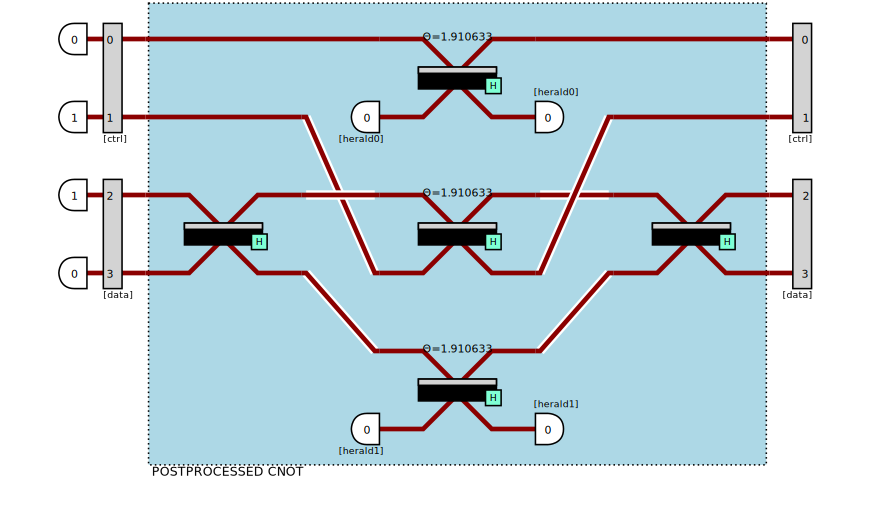

In [4]:
## Ralph's et al. CNot

print(catalog['postprocessed cnot'].doc)
ralph_cnot = catalog['postprocessed cnot'].build_processor()
ralph_cnot.min_detected_photons_filter(0)
## You can set its input state with a LogicalState
ralph_cnot.with_input(pcvl.LogicalState([1, 0]))

pcvl.pdisplay(ralph_cnot, recursive=True, render_size=1.25)

In [5]:
## Exercise: Check/convince yourself that the circuit above is performing a CNOT in the dual rail encoding

In [6]:
## You can sample some output states
cnot_sampler = pcvl.algorithm.Sampler(ralph_cnot)
samples = cnot_sampler.probs()
print(samples['results'])
print("Some output states were not selected because of heralds and post-processing => you can check the global performance")
print("Global performance = ", samples['global_perf'])

{
	|0,1,0,1>: 1
}
Some output states were not selected because of heralds and post-processing => you can check the global performance
Global performance =  0.11111111111111113


In [7]:
## Exercise: Check it performs a CNOT, and explicit the difference between the two types of CNOT

### Exercise

The next circuit comes from the following [paper](https://quantum-journal.org/papers/q-2021-03-29-422/).

![](../_static/img/tuto_circuit_to_reproduce.png)

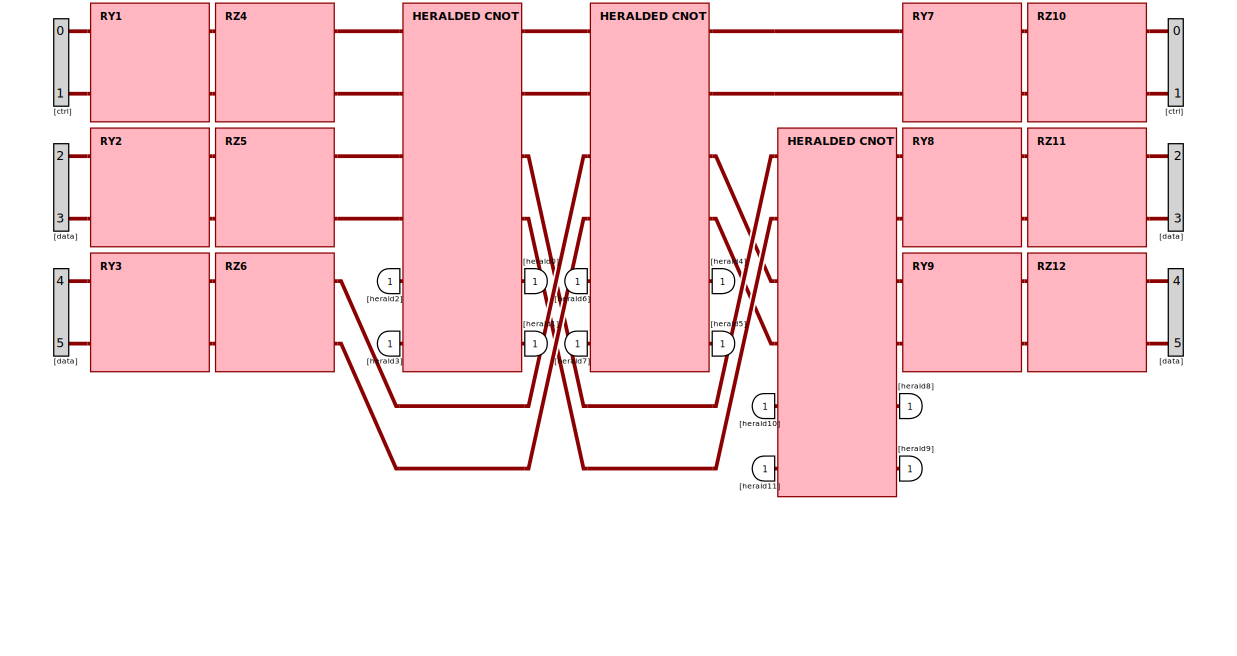

In [8]:
## Exercise: reproduce it in the encoding seen above

## Solution:
# Let's try to implement that circuit properly.
# First, the quantum gates, as coded above :

Rx = lambda i: pcvl.Circuit(2) // (0,PS(np.pi)) // BS.Rx(theta=pcvl.P(f"theta{i}")) // (0,PS(np.pi)) #Be careful for the minus ! We use a convention
Ry = lambda i: pcvl.Circuit(2,name=f"Ry{i}") // BS.Ry(theta=pcvl.P(f"theta{i}"))
Rz = lambda i: pcvl.Circuit(2,name=f"Rz{i}") // BS.H() // circuit_rx // BS.H()
cnot = catalog['heralded cnot'].build_processor()

# Our qubits in the dual rail encoding
q1, q2, q3 = [0,1], [2,3], [4,5]

p = pcvl.Processor("SLOS",6)

for i in range(3):
    p.add(2*i,Ry(i+1)).add(2*i,Rz(i+4))
p.add(q1+q2, cnot)
p.add(q1+q3, cnot)
p.add(q2+q3, cnot)

for i in range(3):
    p.add(2*i, Ry(i+7)).add(2*i, Rz(i+10))

pcvl.pdisplay(p,recursive=False)

## IV. (Optional) Graph states

Graph states can be generated from a `networkx` graph with the `StateGenerator` class from Perceval.

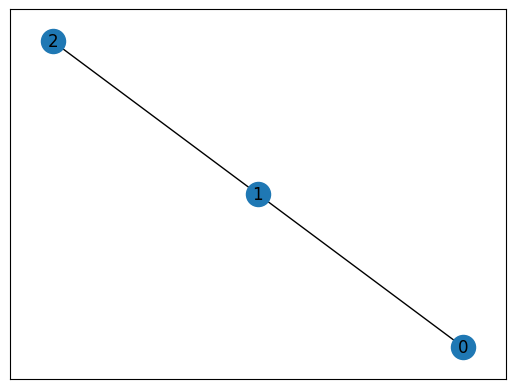

In [9]:
g = nx.Graph()
g.add_nodes_from([0, 1, 2])
g.add_edge(0, 1)
g.add_edge(1, 2)

nx.draw_networkx(g, with_labels=True)

In [10]:
# Set the generator with the dual rail encoding
generator = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL)
graph_state = generator.graph_state(g)
print(graph_state)

0.354*|0,1,1,0,1,0>+0.354*|1,0,1,0,1,0>+0.354*|1,0,1,0,0,1>-0.354*|0,1,0,1,1,0>+0.354*|1,0,0,1,1,0>+0.354*|0,1,1,0,0,1>+0.354*|0,1,0,1,0,1>-0.354*|1,0,0,1,0,1>


In [11]:
## You can sample some output states
h_cnot = catalog['heralded cnot'].build_processor()
cnot_sampler = pcvl.algorithm.Sampler(h_cnot)
h_cnot.with_input(pcvl.LogicalState([0, 0]))

samples = cnot_sampler.samples(10)
print(samples['results'])
print("Some output states were not selected because of heralds and post-processing => you can check the global performance")
print("Global performance = ", samples['global_perf'])

[ |1,0,1,0>, |1,0,1,0>, |1,0,1,0>, |1,0,1,0>, |1,0,1,0>, |1,0,1,0>, |1,0,1,0>, |1,0,1,0>, |1,0,1,0>, |1,0,1,0> ]
Some output states were not selected because of heralds and post-processing => you can check the global performance
Global performance =  0.0740740740740741


This graph state is a Perceval `StateVector`. It can be used as an input in any local computation, using `Processor.with_input()`. When a StateVector is input in a processor, it overrides any noisy source you might have set and is treated as a perfect input.

Also, a state vector cannot be input in any remote simulator or QPU.

In [12]:
p = pcvl.Processor("SLOS", pcvl.Unitary(pcvl.Matrix.random_unitary(6)))  # Use a 6x6 random unitary matrix as a circuit
p.min_detected_photons_filter(3)
p.with_input(graph_state)
sampler = pcvl.algorithm.Sampler(p)
print(sampler.probs()['results'])

{
	|2,0,1,0,0,0>: 0.07217838007769074
	|3,0,0,0,0,0>: 0.01629728389752123
	|2,0,0,1,0,0>: 0.013625994354447368
	|2,1,0,0,0,0>: 0.0040620856129636755
	|2,0,0,0,1,0>: 0.010156376299344788
	|1,2,0,0,0,0>: 0.020436199299593494
	|0,0,1,1,0,1>: 0.004504999982584616
	|0,0,0,2,1,0>: 0.011578227684569996
	|2,0,0,0,0,1>: 0.006618675439388963
	|1,1,1,0,0,0>: 0.010363920834755385
	|0,1,0,0,0,2>: 0.02924539639893664
	|1,1,0,1,0,0>: 0.02114298434440319
	|1,1,0,0,1,0>: 0.0036226046652515073
	|1,0,0,0,0,2>: 0.022013467451546795
	|1,1,0,0,0,1>: 0.021157745102671176
	|1,0,2,0,0,0>: 0.00010708877579463878
	|1,0,1,1,0,0>: 0.0009733189990185643
	|1,0,1,0,1,0>: 0.04210530775214053
	|0,0,0,0,1,2>: 0.00665630259707393
	|0,0,0,1,0,2>: 0.007430931698399973
	|1,0,1,0,0,1>: 0.034957991809063976
	|0,1,2,0,0,0>: 0.02981771822670405
	|0,3,0,0,0,0>: 0.04477955682465291
	|1,0,0,2,0,0>: 0.011568680828278919
	|1,0,0,1,1,0>: 0.025875619120136816
	|1,0,0,1,0,1>: 0.004640039849867683
	|0,2,0,0,0,1>: 0.018571649735125564
	|

That's it ! You have now covered the most important topics of perceval !